In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [2]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f);

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)

a (4000, 8, 21, 6)
b (4000, 8, 21, 6)
L (4000, 8, 21, 6)
ℓ (4000, 8, 21, 6)
H (4000, 8, 21, 6)


In [4]:
compound_positions = encoder_dict["compound_position"].inverse_transform(sorted(set(df["compound_position"]))).tolist() #sorted(set(df["compound_position"])

vertices = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] == ""]
radii = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] and cpos.split("-")[1] == "C6LC"]
diameters = [(i, cpos) for i, cpos in enumerate(compound_positions) if (i, cpos) not in vertices and (i, cpos) not in radii]

vertices = [i for (i, cpos) in vertices]
radii = [i for (i, cpos) in radii]
diameters = [i for (i, cpos) in diameters]

In [5]:
subjects = sorted(set(df["participant"]))
positions = sorted(set(df["compound_position"]))
muscles = model.response

In [6]:
a = posterior_samples[site.a][...]

In [7]:
a.shape

(4000, 8, 21, 6)

In [8]:
encoder_dict["compound_position"].inverse_transform(vertices)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

In [9]:
encoder_dict["compound_position"].inverse_transform(radii)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [10]:
encoder_dict["compound_position"].inverse_transform(diameters)

array(['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW'],
      dtype=object)

In [11]:
norm_y = []
norm_x = []
subset = vertices
target_position = 0

for subject_ind, subject in enumerate(subjects):
    for m_ind, m in enumerate(muscles):
        # Fix the subject index and size index
        a_temp = a[:, subject_ind, subset, m_ind]
        mean_thres = np.nanmean(a_temp[:,target_position,...],axis=(0))
        curr_params = [
            params[:, subject_ind, subset, m_ind, None] for params in params
        ]

        x_temp = np.array([1.2*mean_thres])[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(muscles),*norm_x.shape[2:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects), len(muscles),*norm_y.shape[2:])
norm_y = ma.masked_invalid(norm_y)

In [12]:
a.shape

(4000, 8, 21, 6)

In [13]:
def musc_collapse(label):
    norm_a = a
    norm_a = norm_a / ma.median(a, axis = (2,3), keepdims=True)
    curr_a = norm_a[:,:,label,...]
    curr_a = ma.mean(curr_a, axis = (0))
    paired_diff_eff = curr_a[:,:,None,:] - curr_a[:,None,:,:]
    eff = ma.mean(paired_diff_eff, axis=(-1))
    
    pvalues = []
    for i in range(len(label)):
        for i2 in range(len(label)):
            if i==i2:
                pvalues.append(1)
                continue
            temp_p = stats.wilcoxon(eff[:, i,i2], axis=0).pvalue
            pvalues.append(temp_p)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(label), len(label))

    labels = encoder_dict["compound_position"].inverse_transform(label)

    mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(eff.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

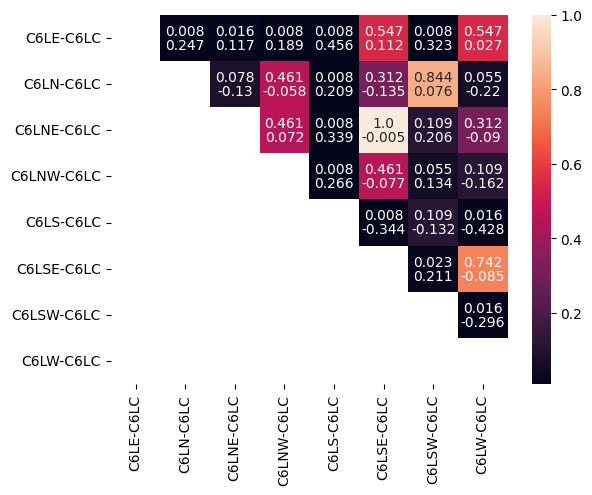

In [16]:
musc_collapse(radii)

In [17]:
y_means = ma.mean(norm_y, axis=(2,4))

In [18]:
y_means.shape

(8, 6, 9)

In [19]:
y_diffs = y_means[:,:,:, None] - y_means[:,:,None,:]

In [20]:
y_diffs.shape

(8, 6, 9, 9)

In [21]:
y_diffs = ma.mean(y_diffs, axis=1)

In [26]:
pvalues = []
for i in range(len(vertices)):
    for i2 in range(len(vertices)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(y_diffs[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(vertices), len(vertices))

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [27]:
pvalues.shape

(9, 9)

<Axes: >

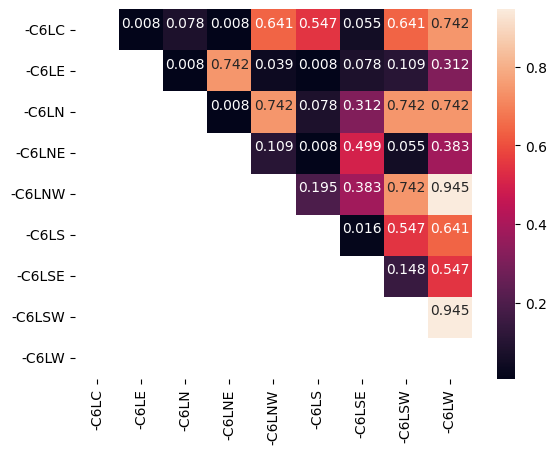

In [28]:
labels = encoder_dict['compound_position'].inverse_transform(vertices)

mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
# sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [29]:
def mep_graph(sub,target):
    norm_y = []
    norm_x = []
    subset = sub
    target_position = target

    for subject_ind, subject in enumerate(subjects):
        for m_ind, m in enumerate(muscles):
            # Fix the subject index and size index
            a_temp = a[:, subject_ind, subset, m_ind]
            mean_thres = np.nanmean(a_temp[:,target_position,...],axis=(0))
            curr_params = [
                params[:, subject_ind, subset, m_ind, None] for params in params
            ]

            x_temp = np.array([1.2*mean_thres])[None, None, None, :]

            temp_thresh = F.rectified_logistic(
                x_temp, #x_temp
                *curr_params
            )
            
            # Remove offset
            temp_thresh = temp_thresh - curr_params[2]
            norm_y.append(temp_thresh)
            norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_x = norm_x.reshape(len(subjects), len(muscles),*norm_x.shape[1:])
    norm_y = np.array(norm_y)
    norm_y = norm_y.reshape(len(subjects), len(muscles),*norm_y.shape[1:])
    norm_y = ma.masked_invalid(norm_y)

    y_means = ma.mean(norm_y, axis=(2,4))

    y_diffs = y_means[:,:, :,None] - y_means[:,:,None,:]
    y_diffs = ma.mean(y_diffs, axis=1)

    pvalues = []
    for i in range(len(subset)):
        for i2 in range(len(subset)):
            if i==i2:
                pvalues.append(1)
                continue
            temp_p = stats.wilcoxon(y_diffs[:, i,i2], axis=0).pvalue
            pvalues.append(temp_p)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(subset), len(subset))

    labels = encoder_dict['compound_position'].inverse_transform(subset)

    mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [30]:
encoder_dict["compound_position"].inverse_transform(vertices)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

In [31]:
a.shape

(4000, 8, 21, 6)

In [32]:
arr = a[:,:,:,:]


In [33]:
a_norm = arr / ma.median(arr, axis=(2,3), keepdims=True)

In [81]:
vertices

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [34]:
a_norm = a_norm[:,:,vertices,:]

In [35]:
a_mean = ma.mean(a_norm, axis=0)

In [36]:
a_mean.shape

(8, 9, 6)

In [37]:
encoder_dict["compound_position"].inverse_transform(vertices)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

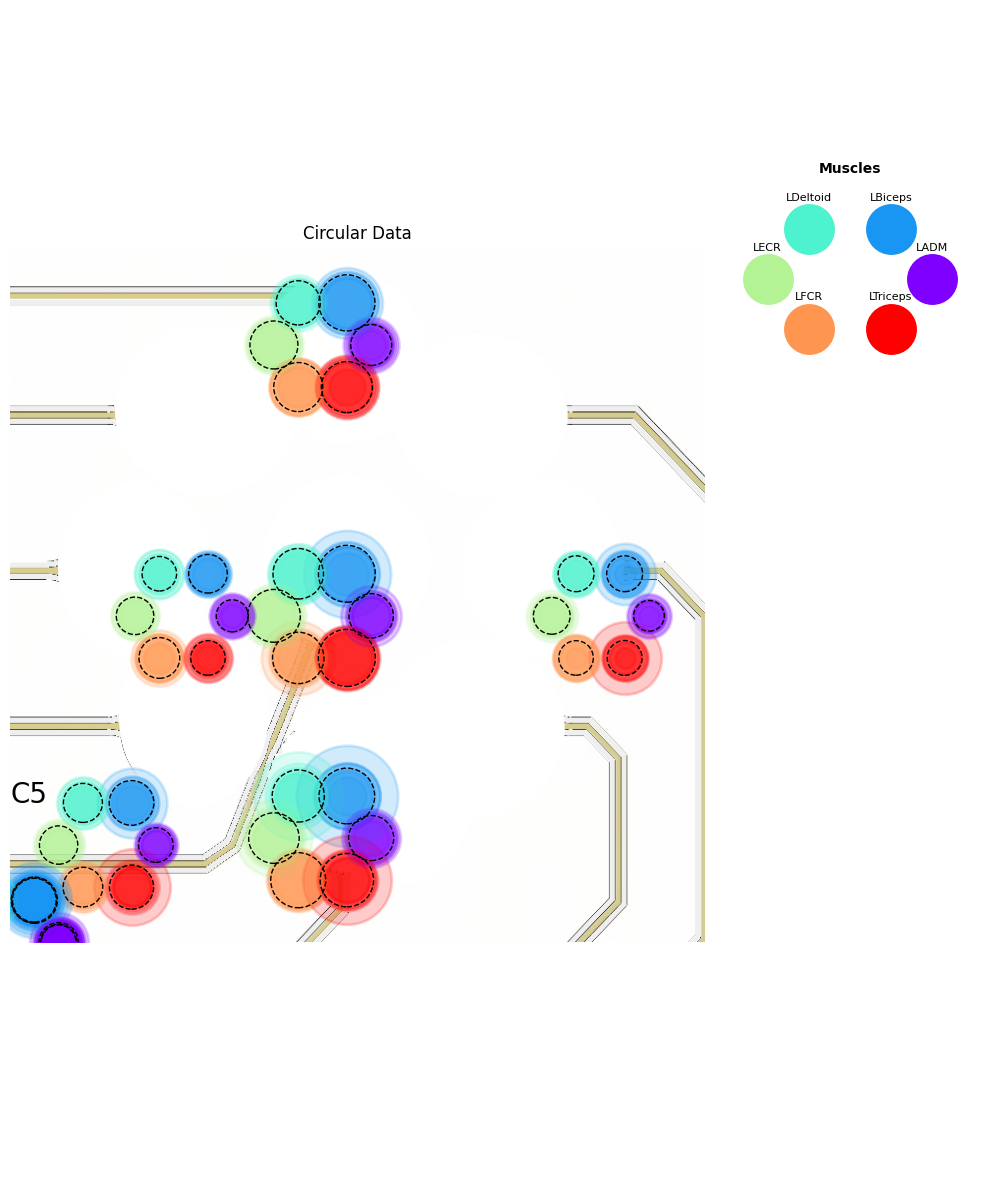

In [74]:
a_mean = a_mean.copy() if not a_mean.flags.writeable else a_mean
colors = model._get_colors(model.n_response)
colors = colors.copy() if not colors.flags.writeable else colors

x_vals_vertices = {"C":(225, 235),"E":(425, 235), "N":(225, 430), "NE":(70, 70), 
                   "NW":(0, 0),"S":(225, 75), "SE":(0, 0), "LW":(0, 0),
                   "W":(125, 235)}

# Plotting
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1.5])



ax_image = fig.add_subplot(gs[0])
ax_image.set_axis_off()  # Hide axis
ax_legend = fig.add_subplot(gs[1])
# Function to plot the muscle rings
def plot_ring(center, group, means, mask):
    radius = 35
    angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)
    alpha = 0.2            
    for s, ind in enumerate(subjects):
        for musc_idx, angle in enumerate(angle_offsets):
            offset_x = radius * np.cos(angle)
            offset_y = radius * np.sin(angle)
            if means[s,:].mask.all():
                continue
            eff_size = (1 / means[s][musc_idx]) * 1100
            
            ax_image.scatter(
                center[0] + offset_x,
                center[1] + offset_y,
                s=eff_size,
                alpha=alpha,
                color=colors[musc_idx],
                linewidth=2,
            )

# Plot for C5 and C6 muscle locations
for i, (key, center) in enumerate(x_vals_vertices.items()):
    plot_ring(center, "C5", a_mean[:,i,:], a_mean.mask)

angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)
radius = 35
c5_means = a_mean.mean(axis=0)
c6_means = a_mean.mean(axis=0)

for i, (key, center) in enumerate(x_vals_vertices.items()):
    for musc_idx, angle in enumerate(angle_offsets):
        # if means[s][musc_idx].mask:
        #     continue
        offset_x = radius * np.cos(angle)
        offset_y = radius * np.sin(angle)
        temp_mean = c5_means[:,musc_idx] 
        eff_size = (1 / temp_mean[i]) * 1100
        alpha = 0           
        muscle_name = muscles[musc_idx]

        ax_image.scatter(
            center[0] + offset_x,
            center[1] + offset_y,
            s=eff_size,
            facecolor = 'none',
            linewidth=1,
            edgecolor = 'black',
            linestyle='dashed',
            
        )

# Customize plot
im = plt.imread("/home/andres/L_TYPE.png")
ax_image.text(0, 100, "C5", fontsize= 20)

ax_image.set_title("Circular Data")
ax_image.set_axis_off()
ax_image.imshow(im, extent=[0, 500, 0, 500])
# Create legend with a ring of circles for each muscle
legend_center = (0.5, 0.77)  # Legend position in normalized axis coordinates
legend_radius = 0.07         # Radius for legend ring
angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)

# Draw circles and text for legend
for musc_idx, angle in enumerate(np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)):
    offset_x = legend_radius * np.cos(angle)
    offset_y = legend_radius * np.sin(angle)
    ax_legend.scatter(
        legend_center[0] + offset_x*4.5,
        legend_center[1] + offset_y*0.7,
        s=1200,  # Fixed size for legend circles
        color=colors[musc_idx],
        alpha=1.0,
        transform=ax_legend.transAxes,
        zorder=10,
        linewidth=2
    )
    ax_legend.text(
        legend_center[0] + offset_x*4.5,
        legend_center[1] + offset_y*0.7+0.027,
        muscles[musc_idx],
        fontsize=8,
        ha="center",
        va="center",
        transform=ax_legend.transAxes
    )

# Add title for the legend
ax_legend.text(
    legend_center[0],
    legend_center[1] + legend_radius+0.024,
    "Muscles",
    transform=ax_legend.transAxes,
    fontsize=10,
    ha="center",
    va="center",
    fontweight="bold"
)
ax_legend.set_axis_off()
plt.tight_layout()
plt.show()


In [106]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/L_CIRC/rad_selectivity_means.pkl"

with open(src, "rb") as f:
    sel_rad= pickle.load(f);

In [104]:
a_mean = ma.mean(a_mean, axis = -1)

In [105]:
a_mean.shape

(8, 8)

In [107]:
avg_eff = ma.mean(a_mean, axis=0)
avg_sel = ma.mean(sel_rad, axis=0)

In [108]:
sem_eff = stats.sem(1/a_mean, axis=0)
sem_sel = stats.sem(sel_rad, axis=0)

In [112]:
encoder_dict["compound_position"].inverse_transform(radii)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [113]:
1/avg_eff

masked_array(data=[0.8061688248935165, 1.0065275367159092,
                   0.8901760513695369, 0.9514001659012761,
                   1.2743492511237438, 0.8862052557359789,
                   1.0904635801907816, 0.8243640492193536],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [117]:
avg_sel

masked_array(data=[0.8493184170823165, 0.801122898564941,
                   0.8398088152839318, 0.6414490794320726,
                   0.7248068806537595, 0.6581157646367124,
                   0.7855034286478446, 0.6508629596262655],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

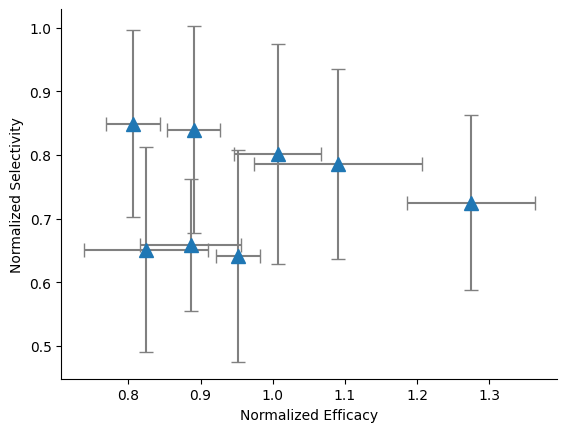

In [109]:
plt.errorbar(x=1/avg_eff, y=avg_sel, yerr=sem_sel, xerr=sem_eff, fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()

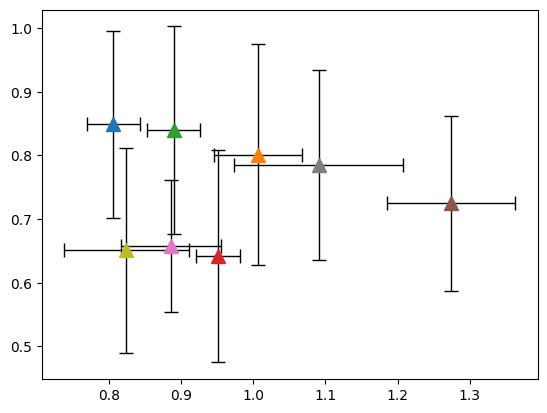

In [116]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x, y, xerr, yerr, colors in zip(1/avg_eff, avg_sel, sem_eff, sem_sel, colors):
    plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='^', ms = 10,ecolor='black', elinewidth=1, capsize=5, color = colors)

In [71]:
a_diff = a_mean[:,:, None,:] - a_mean[:,None,:,:]

In [72]:
a_diff.shape

(8, 4, 4, 6)

In [73]:
a_diff_mean = ma.mean(a_diff, axis=3)

In [74]:
stats.wilcoxon(a_diff_mean[:, 0,1], axis=0)

WilcoxonResult(statistic=0.0, pvalue=0.0078125)

In [75]:
a_diff_mean.shape

(8, 4, 4)

In [76]:
pvalues = []
for i in range(4):
    for i2 in range(4):
        if i==i2:
            pvalues.append(1)
        else:
            pvalues.append(stats.wilcoxon(a_diff_mean[:, i,i2], axis=0).pvalue)

In [77]:
labels = encoder_dict["compound_position"].inverse_transform(diameters)

In [78]:
a_diff_mean.mean(axis=0).data.shape

(4, 4)

In [79]:
pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(diameters), len(diameters))

<Axes: >

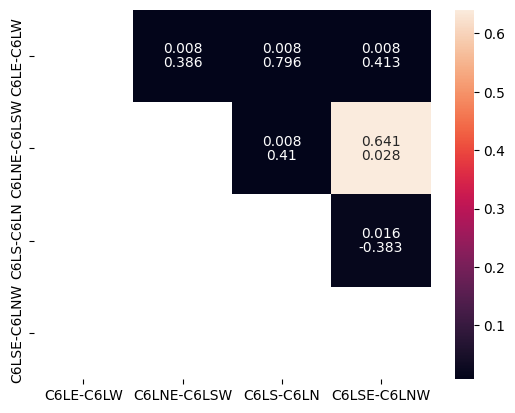

In [80]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(a_diff_mean.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)